# Plotting outputs from Gaussian - Electronic Spectra

## Description
This Python script reads and plots linear-response time dependent density functional theory spectra from Gaussian output files. It processes the data to create smooth, normalized plots of spectral intensities against energy levels, using either Lorentzian or Gaussian smoothing functions. Designed for easy use in Jupyter Notebook, the script lets you see the step-by-step transformation of your data, helping you understand and visualize the spectra more effectively.

In [1]:
#Allow Jupyter notebooks to directly display matplotlib images in line:
%matplotlib inline

## Initialization of constants used:

Here we tell the script the resolution that we broaden across (resolution), and the broadening factor (sigma).  The energetic range which we plot in (enMin, enMax).  We also tell the program where to find the data we are using (fileList, given in RELATIVE paths to the data files), and what we want to have them labeled as in the final plot (legends).

In [2]:
resolution = 0.01
sigma = 0.14
shift=0
enMin = 3
enMax = 13

fileList = ['data/TD_ethane.log', \
            'data/benzophenone.log', \
            ]
legends = ['ethane', \
           'benzophenone', \
           ]

## Including Libraries

Instead of a room full of books, we have groupings of code that have already been implemented for us.  Available through installers such as pip or conda, you can take advantage of work that other people have already written to use in your packages.  Called through the 'import' keyword we will tell python to search for and include functions implemented in files external to our current program.  If your python file is getting too long you can even move your own functions to outside files and import them here too:

In [3]:
#load libraries 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy

In [4]:
#change font and line preferences
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : '12'}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth']=2

## Functions in Python

Functions in Python are reusable blocks of code that perform a specific task, enabling modular and organized programming. They take input in the form of arguments, process the input, and return an output, making code more efficient and easier to maintain. Additionally, functions enhance code readability and facilitate debugging by isolating different functionalities into self-contained units.

Here we are coding some specific functions. Breifly: 
* `extract` - Extracts energy and intensity data from the specified Gaussian output file. It uses the bash command `grep` to read lines containing "Excited State" information, loads them into a temporary file, parses the energy and intensity values, and removes the temporary file.  The information is returned as a NumPy array.
* `smooth` - Applies Lorentzian smoothing to the spectral data. It adjusts the intensity values based on a Lorentzian distribution centered around each energy value.
* `gauSmooth` - Applies Gaussian smoothing to the spectral data. Similar to the Lorentzian smoothing function, but uses a Gaussian distribution for smoothing.
* `normalize` - Normalizes the intensity values of the smoothed data to the maximum value between the plots, and attempts to scale the stick information.

In [5]:
def extract(fileNM):
  responses = []
  bashCommand = 'grep -h "Excited State" ' + fileNM + '>tmpInt.txt'
  os.system(bashCommand)
  with open('tmpInt.txt') as fileIn:
    for line in fileIn:
      tmp = line.split()
      #print("TMP: ", tmp)
      try:
        energy = float(tmp[4])
      except:
        energy = float(tmp[3])
      try:
        intensity = float(tmp[8].split("f=")[1])
      except:
        intensity = float(tmp[7])
      #if intensity > 0:#Filter out zero osc. str. roots
      responses.append([energy, intensity])
  os.system('rm tmpInt.txt')
  return np.asarray(responses)

def smooth(dataOut, stick, enMin, sigma):
  #Lorentzian Fxn
  EN = stick[:,0]
  VALS = stick[:,1]
  for i, energy in enumerate(EN):
    dataOut[:,1] += VALS[i] * (1 / np.pi) * ((.5 * sigma)/\
                    (np.power(energy - dataOut[:,0], 2) + (.5 * sigma) ** 2))
  return dataOut

def gauSmooth(dataOut, stick, enMin, sigma):
  #Gaussian Smoothing
  EN = stick[:,0]
  VALS = stick[:,1]
  for i, energy in enumerate(EN):
    dataOut[:,1] += VALS[i] * (1 / (sigma * np.sqrt(2*np.pi))) * \
      np.exp(-(energy-dataOut[:,0])**2 / (2*sigma)**2)
  return dataOut

def normalize(sticks, plot, ymax):
  #ymax = max(plot[:,1])
  for i in range(len(sticks)):
    sticks[i,1] = sticks[i,1] / (.5 * ymax)
  for i in range(len(plot)):
    plot[i,1] = plot[i,1] / ymax
  return [sticks, plot]

## The Main Block 
The main block of the script performs the following tasks:
* Iterates over the `fileList`, extracting spectral data using the `extract` function.
* Applies smoothing to the data and stores the results in `plots`.
* Normalizes the data to ensure consistent intensity scaling across plots.

In [6]:
##MAIN PROGRAM BEGINS##

plots = [[] for x in range(len(fileList))]
sticks = [[] for x in range(len(fileList))]
ymax = 0.

for i, fileNM in enumerate(fileList):
  print("DOING: ", fileNM)
  #if ".txt" in fileNM:#The .txt files
  #  tmpSticks = extractTXT(fileNM) 
  #else:
  sticks[i] = extract(fileNM)
  tmpPlot = np.asarray([[x,0.] for x in np.arange(enMin, enMax+resolution, resolution)])
  gauSmooth(tmpPlot, sticks[i], enMin, sigma)
  tmpMax = max(tmpPlot[:,1])
  if tmpMax > ymax:
    ymax = tmpMax
  plots[i] = tmpPlot
  #expPlots[i] = extractTXT(expFiles[i])
  
if ymax > 0:
  for i in range(len(fileList)):
    sticks[i], plots[i] = normalize(sticks[i], plots[i], ymax)
else:
  print("NO INTENSITIES FOUND, BE WARY")

DOING:  data/TD_ethane.log
DOING:  data/benzophenone.log


## Output Plots

Lastly, the program is outputting an image called LRplts.png which will appear in your current directory when the run completes. You can double-click LRplts.png to view it in JupyterLab.
* Creates a figure with subplots for each dataset, sharing the x-axis.
* Plots the smoothed spectral data and adds vertical lines for the raw stick data.
* Annotates each subplot with the corresponding legend and adjusts the y-axis ticks for better visualization.
* Adds a shared y-axis label and an x-axis label.
* Finally, saves the plot as "LRplts.png".

Scipy is used here to return information about the spectra.  We print the location of peaks for each spectrum, and also return the energy and response number of the largest response under the peak.  We can use this to visualize MO contributions to the various peaks.

Responses in ethane :
	Peak = 12.67 eV; max(12.65) = 7
Responses in benzophenone :
	Peak = 3.90 eV; max(3.90) = 1
	Peak = 5.34 eV; max(5.34) = 4
	Peak = 6.52 eV; max(6.59) = 9


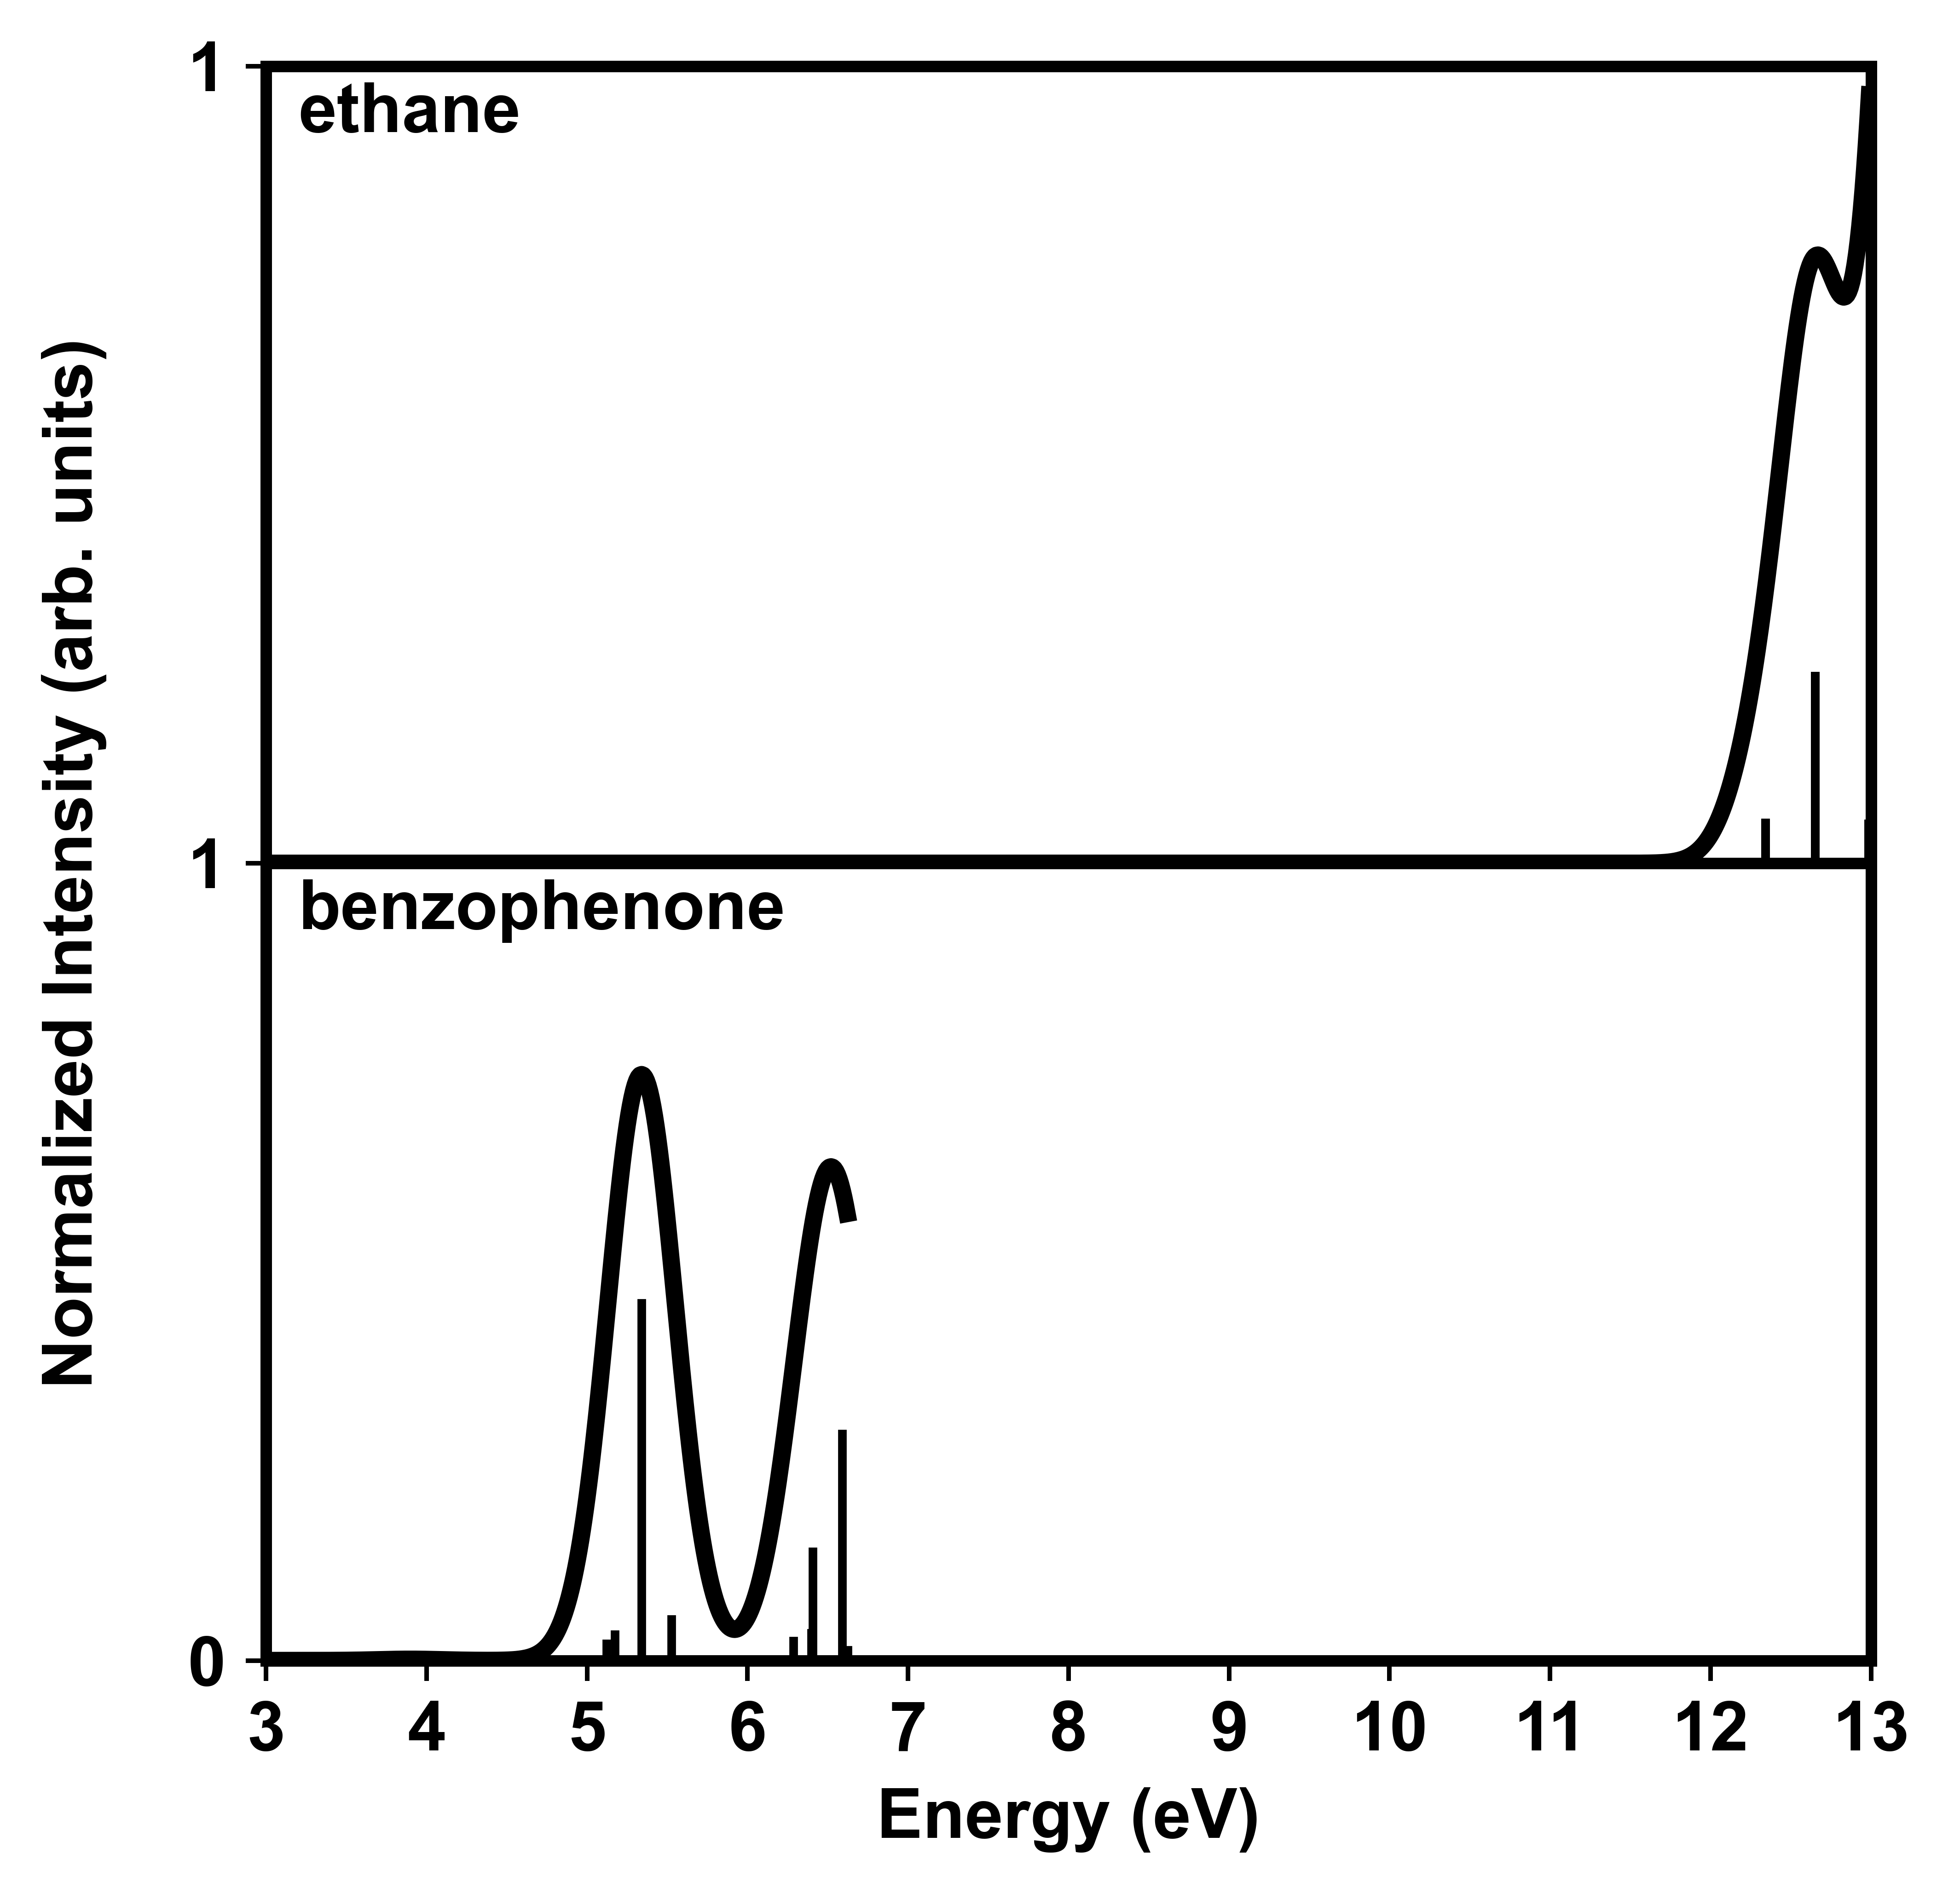

In [7]:
#PLOTTING:
fig, ax = plt.subplots(len(fileList), sharex=True, gridspec_kw={'hspace': 0}, figsize=(5,5),dpi=900,squeeze=False)
for i, p in enumerate(plots):
  p = np.transpose(p)
  st = np.transpose(sticks[i])
  
  #We have not calculated all roots, so we need to cut off the spectrum where we have no information
  maximumPlotEn = min(max(st[0]), max(p[0]))
  EnIndex = next(x for x, val in enumerate(p[0]) if val>=maximumPlotEn)
  p = np.transpose(np.transpose(p)[:EnIndex])

  #Find, and print the peaks in the broadened spectrum; print the largest response under the peak
  peaks = scipy.signal.find_peaks(p[1],threshold=0.000001)
  widths = scipy.signal.peak_widths(p[1], peaks[0])[0]
  print("Responses in %s :" %(legends[i]))
  for k, peak in enumerate(peaks[0]):
    #Find the primary excitation (en val/osc. str):
    peak_min = p[0][max(0,peak - int(widths[k] / 2))]
    peak_max = p[0][min(len(p[0])-1, peak + int(widths[k] / 2))]
    indicies = np.where(np.logical_and(st[0]>=peak_min, st[0]<=peak_max))[0]
    if len(indicies) > 0:  
      if len(indicies) > 1:
        #Multiple responses under the curve:
        max_resp = indicies[0]+np.argmax(st[1][indicies[0]:indicies[-1]])
      else:
        max_resp = indicies[0]
      print("\tPeak = %0.2f eV; max(%0.2f) = %i" %(p[0][peak],st[0][max_resp], max_resp+1))

  ax[i,0].plot(p[0] + shift, p[1],color='k', linewidth=3, label="Theoretical")
  
  for v in range(len(st[0])):
    ax[i,0].axvline(x=st[0,v] + shift, ymin=0, ymax=st[1,v], color='k')
  
  
  ax[i,0].set_xlim([int(enMin + shift),int(enMax + shift)])
  tickIter = int((int(enMax + shift) - int(enMin + shift)) / 8)
  if tickIter > 0:
    #No decimals in xray plots:
    ax[i,0].set_xticks(list(np.arange(int(enMin + shift), \
                        int(enMax+shift+tickIter), tickIter)))

  ax[i,0].set_ylim([0,1])
  if i == len(fileList)-1:
    ax[i,0].set_yticks([0.,1])
  else:
    ax[i,0].set_yticks([1])
  
  ax[i,0].text(0.02, 0.98, legends[i], ha='left', va='top', transform=ax[i,0].transAxes)


#Shared Y-Label
fig.add_subplot(111,frameon=False)                                              
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)                                                                 
plt.ylabel("Normalized Intensity (arb. units)",weight='bold') 

for ax in fig.get_axes():
  ax.label_outer()

plt.xlabel("Energy (eV)", weight='bold')
plt.savefig("LRplts.png")
plt.show()